In [1]:
# Importing relevant modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from dynesty import NestedSampler
np.random.seed(1)

# Nested sampling

Nested sampling is a method for Bayesian evidence quantification that was developed by J. Skilling {cite}`skilling_nested_2006`. 
We won't look in detail at the nested sampling algorithm, however for the interested reader I suggest taking a look at the textbook published by D. S. Sivia and J. Skilling {cite}`sivia_data_2005` and the [background section of the `dynesty` package](https://dynesty.readthedocs.io/en/latest/overview.html).
Instead, this section will focus on using the `dynesty` package to quantify the two models mentioned previously. 
Then the next section will allow you to apply this method to the interpretation of some neutron reflectometry data.

Firstly, let's get the data and models back. 

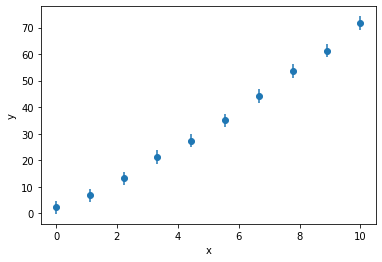

In [2]:
x, y, yerr = np.loadtxt('nested.txt', unpack=True)
plt.errorbar(x, y, yerr, marker='o', ls='')
plt.xlabel('x')
plt.ylabel('y') 
plt.show()

The potential models are either linear or quadratic:
1. $y = m x + c $ 
2. $y = ax^2 + bx + c$

In [3]:
def model1(x, m, c):
    return m * x + c

def model2(x, a, b, c):
    return a * x ** 2 + b * x + c

Now we need to create function that will return the [log-likelihood](./likelihood) for a model and a given set of parameters.

In [4]:
def loglike(p, x, y, yerr, model):
    return -0.5 * np.sum(np.square((y - model(x, *p)) / yerr) + np.log(2 * np.pi * yerr))

Since the determination of the evidence is the integral of the likelihood and the prior for each parameter, we must define these. 
These must be bounded integrals, i.e. they cannot start or end at infinity. 
For this example, uninformative priors (where all values within the bounds are equally likely) where used. 
These are defined within the prior transform function below. 

In [5]:
def pt_model1(u): 
    """
    The prior transform for model one, 
    where 0<=m<10 and -5<=c<5.
    
    Args:
        u (array_like): Object to be transformed.
    
    Returns:
        (array_like): Priors.
    """
    x = np.array(u)
    x[0] = uniform.ppf(u[0], 0, 10)
    x[1] = uniform.ppf(u[1], -5, 5)
    return x 

def pt_model2(u): 
    """
    The prior transform for model two, 
    where 0<=a<1, 0<=b<10, and 0<=c<5.
    
    Args:
        u (array_like): Object to be transformed.
    
    Returns:
        (array_like): Priors.
    """
    x = np.array(u)
    x[0] = uniform.ppf(u[0], 0, 1)
    x[1] = uniform.ppf(u[1], 0, 10)
    x[2] = uniform.ppf(u[2], 0, 5)
    return x 

We can then set up the `NestedSampler`-class objects. 
Note that because the `loglike` arguments are not just the parameters being evaluated then we must include the additional arguments in the `logl_args` keyword argument.
Below, we set up the sampler for each of the two models.

In [6]:
sampler1 = NestedSampler(loglike, pt_model1, 2, logl_args=[x, y, yerr, model1])
sampler2 = NestedSampler(loglike, pt_model2, 3, logl_args=[x, y, yerr, model2])

The sampling is then performed with the `run_nested()` method, when running locally setting `print_progress` to `True` can be helpful in diagnostics. 

In [7]:
sampler1.run_nested(print_progress=False)

In [8]:
sampler2.run_nested(print_progress=False)

These will run until some stopping criteria is reached, by default this stopping criteria is that the change in the estimated log-evidence is less than 0.001.
We can visualise the convergence of the log-evidence by examing the `results` attribute.

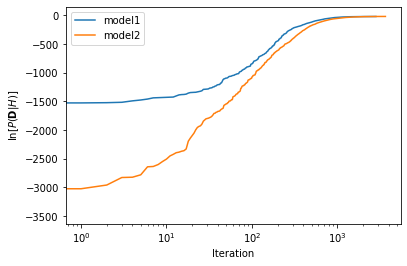

In [9]:
plt.plot(sampler1.results['logz'], label='model1')
plt.plot(sampler2.results['logz'], label='model2')
plt.legend()
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('$\ln[P(\mathbf{D}|H)]$')
plt.show()

The final estimate for the log-evidence is the value that we are interested in. 
We mentioned previously that the simpler model 2 was twice as common as the more complex model 1. 
Therefore we can define these as log-priors. 

In [10]:
model1_logz = sampler1.results['logz'][-1]
model2_logz = sampler2.results['logz'][-1]
model1_logp = np.log(2 / 3)
model2_logp = np.log(1 / 3)

From these, we can find the log-posteriors and therefore the Bayes' factor. 

In [11]:
model1_logpost = model1_logz + model1_logp
model2_logpost = model2_logz + model2_logp
bayes_factor = 2 * (model2_logpost - model1_logpost)

In [12]:
print('2ln(B) = {:.4f}'.format(bayes_factor))

2ln(B) = 0.7489


The Bayes' factor is between 0 and 2, indicating that the more complex model is "not worth more than a bare mention". 
Note that if our prior understanding of these two models was not integrated into this comparison, there would be "positive" evidence for the more complex model.

In [13]:
no_prior = 2 * (model2_logz - model1_logz)
print('Bayes\' factor with no prior = {:.4f}'.format(no_prior))

Bayes' with no prior = 2.1352


Hopefully, from this example you will have seen how to create a `dynesty` compatible model that we can find the log-evidence for and how we can use this for model comparison. 
The exercise associated with this involves applying this methodology to model comparison in neutron reflectometry analysis but hopefully you can see the broader utility of this subject. 